---

title: **Interpolation Study** (*v 1.0*)

author: Tiago Ribeiro

date: 15/03/2023

other methods (Flow Net): https://github.com/sampepose/flownet2-tf

other methods (PWC Net): https://github.com/hellochick/PWCNet-tf2

---

In [29]:
from watermark import watermark
print(watermark(author='Tiago Ribeiro', github_username='Tiago1Ribeiro', 
                current_date=True, datename=True, iso8601=False, current_time=True, 
                timezone=True, python=True, conda=True, machine=True, 
                iversions=True,  globals_= globals()))



Author: Tiago Ribeiro

Github username: Tiago1Ribeiro

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

conda environment: interpol

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 5, GenuineIntel
CPU cores   : 16
Architecture: 64bit

pyspatiotemporalgeom: 0.2.7.5



In [149]:
import cv2 
from glob import glob
import os
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.wkt import loads

### Data sources

In [150]:
DIR = os.getcwd()
SEGS_IMGS_DIR = "E://BurnedAreaUAV_files//Results//segs_base"
SEGS_POL_FILE = "E://BurnedAreaUAV_files//Results//WKT_files//segs_unet_base.wkt"
FRAMES_DIR = "E://BurnedAreaUAV_files//Raw_data//frames"
frames_paths = glob(os.path.join(FRAMES_DIR, "*.png"))

In [151]:
# read wkt file
wkt_file = open(SEGS_POL_FILE, 'r')
# list of polygons
multipolygons = wkt_file.readlines()

#### get_biggest_polygon

In [154]:
def get_biggest_polygon(multipolygon):
    # Get the area of all mutipolygon parts
    areas = [i.area for i in list(loads(multipolygon).geoms)]
    # Get the area of the largest part
    max_area = areas.index(max(areas))    
    # Return the index of the largest area
    return list(loads(multipolygon).geoms)[max_area]

In [155]:
# Get the biggest polygon from each multipolygon
polygons = list()
for multipolygon in multipolygons:
     polygon = get_biggest_polygon(multipolygon)
     polygons.append(polygon)

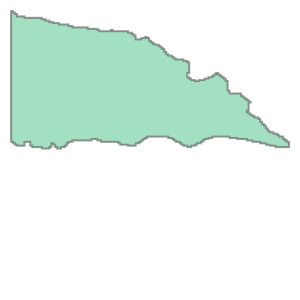

In [201]:
loads(multipolygons[0])

### Visualization segmentation polygons, before and after filtering

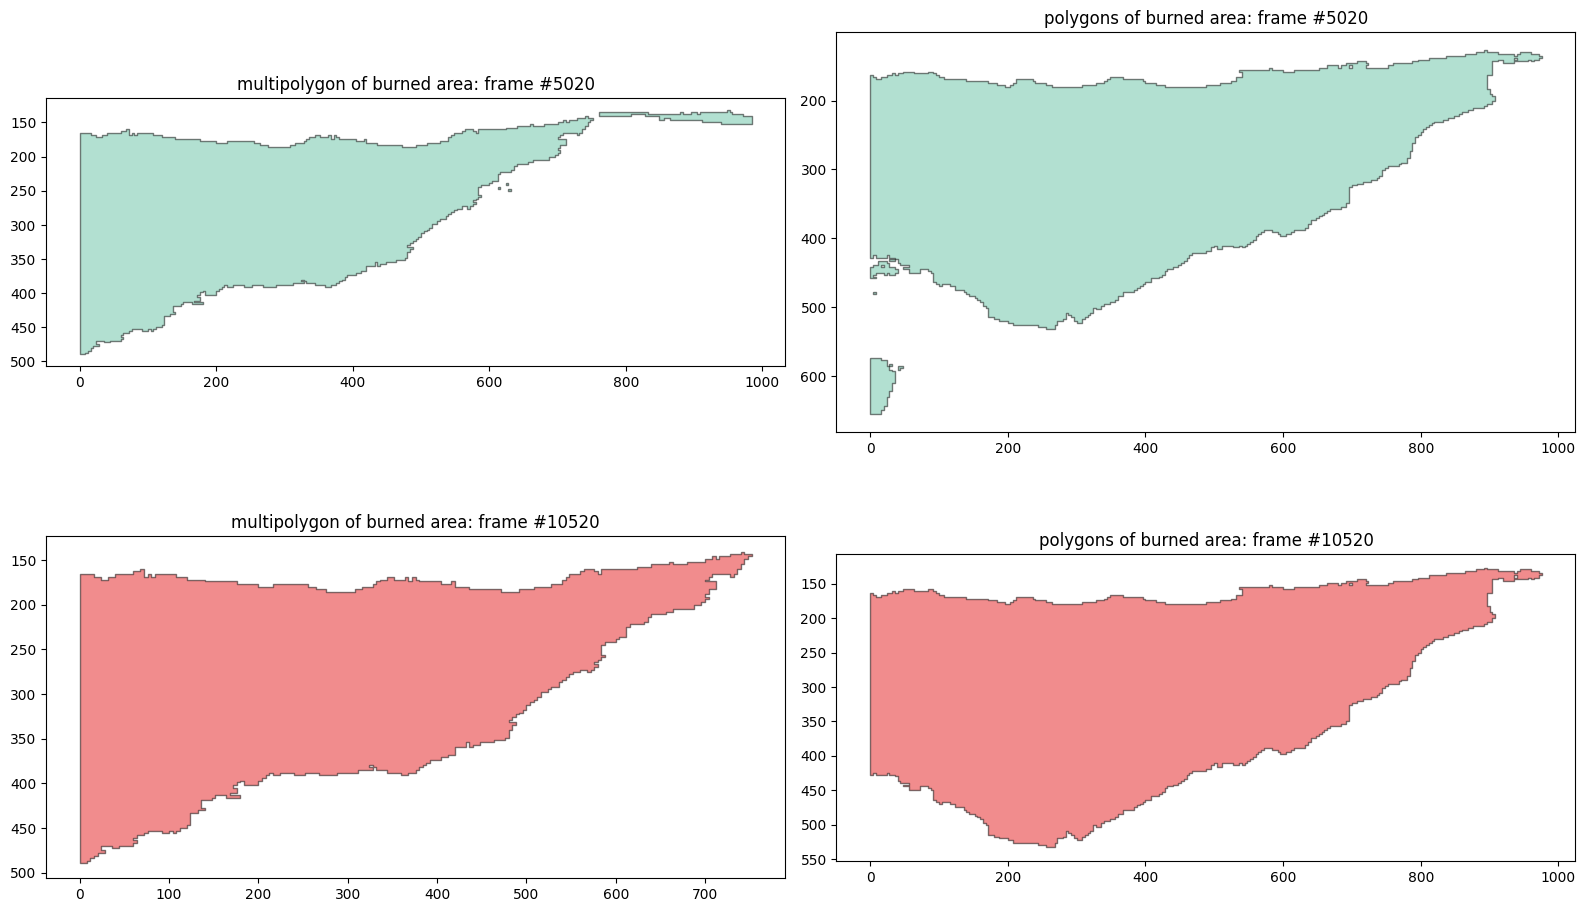

In [13]:
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd


# frames with multiple polygons
frame1= 5020
frame2 = 10520

gd1 = gpd.GeoSeries(loads(multipolygons[frame1]))
gd2 = gpd.GeoSeries(loads(multipolygons[frame2]))
gd3 = gpd.GeoSeries(polygons[frame1])
gd4 = gpd.GeoSeries(polygons[frame2])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

gd1.plot(ax=axs[0,0], cmap='Set2', alpha=0.5, edgecolor='k').invert_yaxis()
axs[0,0].set_title(f'multipolygon of burned area: frame #{frame1}')

gd2.plot(ax=axs[0,1], cmap='Set2', alpha=0.5, edgecolor='k').invert_yaxis()
axs[1,0].set_title(f'multipolygon of burned area: frame #{frame2}')

gd3.plot(ax= axs[1,0], cmap='Set1',  alpha=0.5, edgecolor='k').invert_yaxis()
axs[0,1].set_title(f'polygons of burned area: frame #{frame1}')

gd4.plot(ax= axs[1,1], cmap='Set1', alpha=0.5, edgecolor='k').invert_yaxis()
axs[1,1].set_title(f'polygons of burned area: frame #{frame2}');

plt.tight_layout()

### Shapely to raster conversion

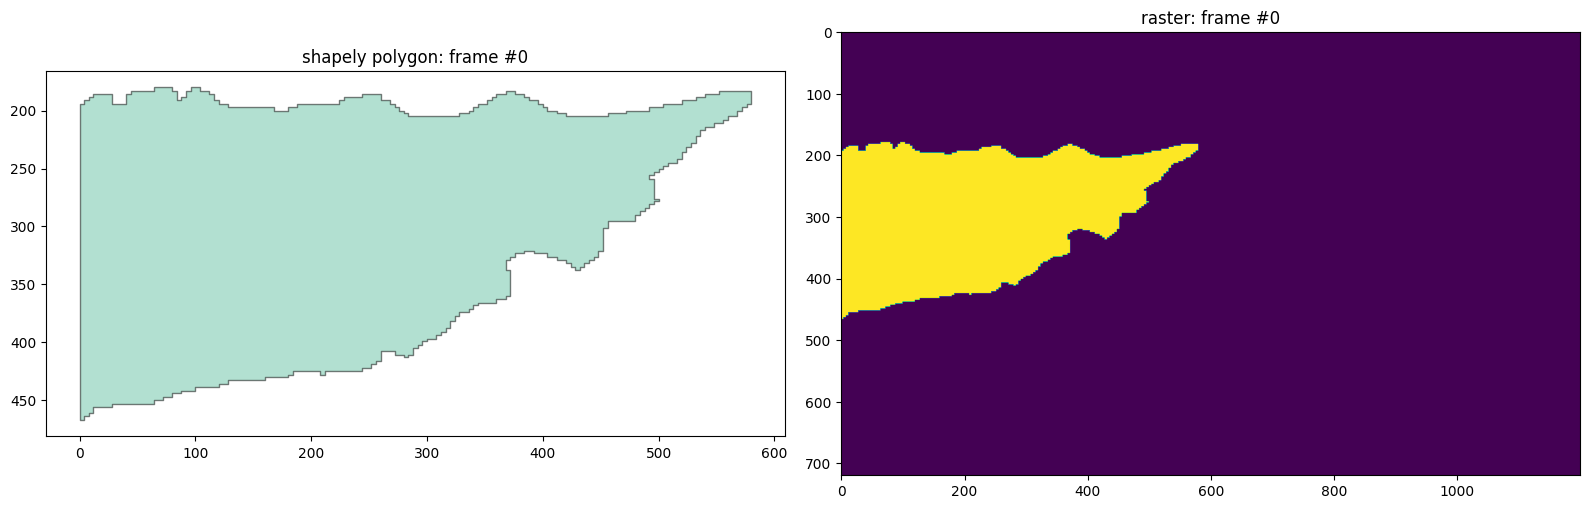

In [198]:
import rasterio.features

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

gd = gpd.GeoSeries(polygons[0])
gd.plot(ax=axs[0], cmap='Set2', alpha=0.5, edgecolor='k').invert_yaxis()
axs[0].set_title(f'shapely polygon: frame #{0}')

img = rasterio.features.rasterize([polygons[0]], out_shape=(720, 1200))
axs[1].imshow(img)
axs[1].set_title(f'raster: frame #{0}');

plt.tight_layout()

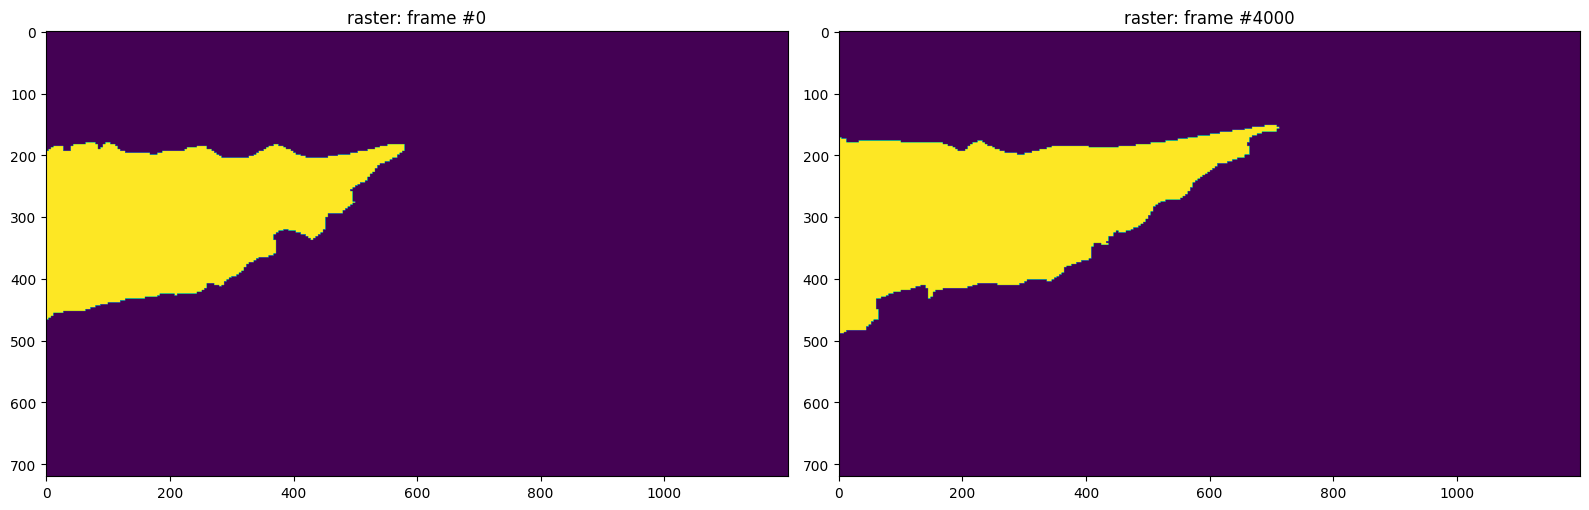

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

frame1 = 0
frame2 = 4000

img1 = rasterio.features.rasterize([polygons[frame1]], out_shape=(720, 1200))
img2 = rasterio.features.rasterize([polygons[frame2]], out_shape=(720, 1200))

axs[0].imshow(img1)
axs[0].set_title(f'raster: frame #{frame1}');

axs[1].imshow(img2)
axs[1].set_title(f'raster: frame #{frame2}');

plt.tight_layout()

"Algorithm taken from [Efficient Semiautomatic Segmentation of 3D Objects in Medical Images](https://www.researchgate.net/publication/221400411_Efficient_Semiautomatic_Segmentation_of_3D_Objects_in_Medical_Images), Schenk *et al*, 2000\n"

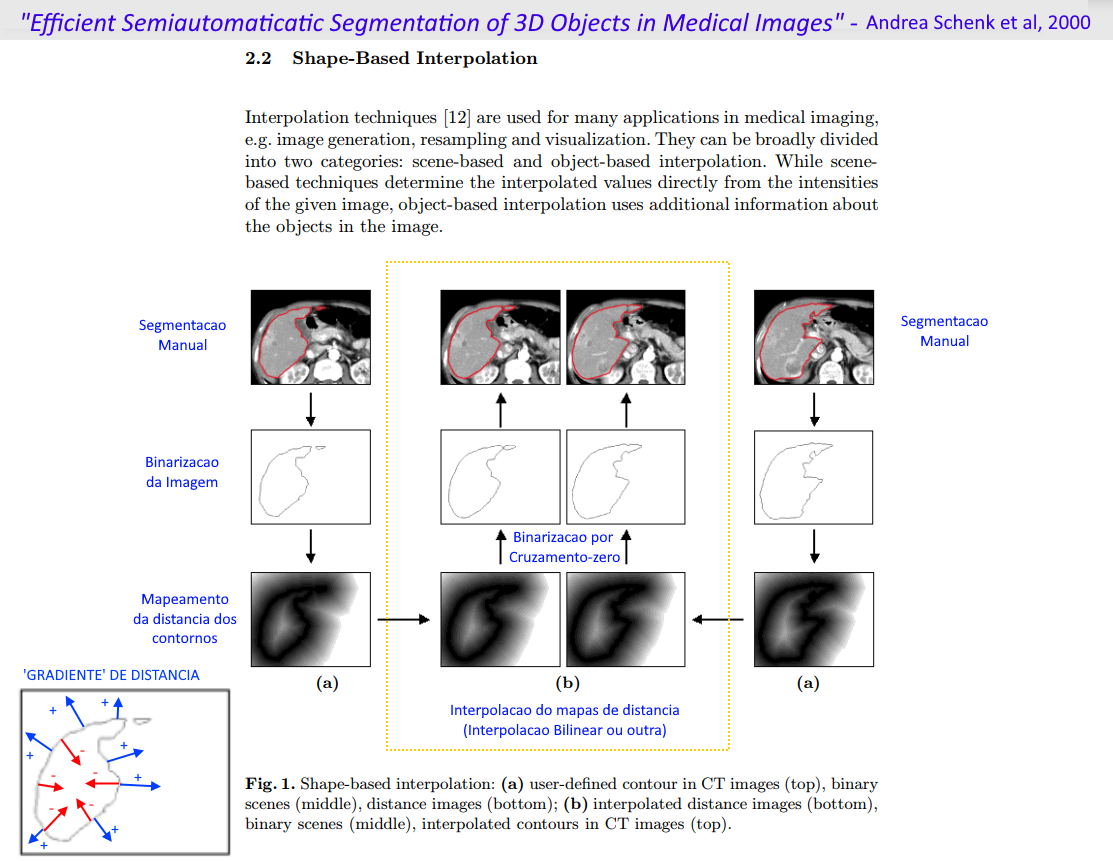

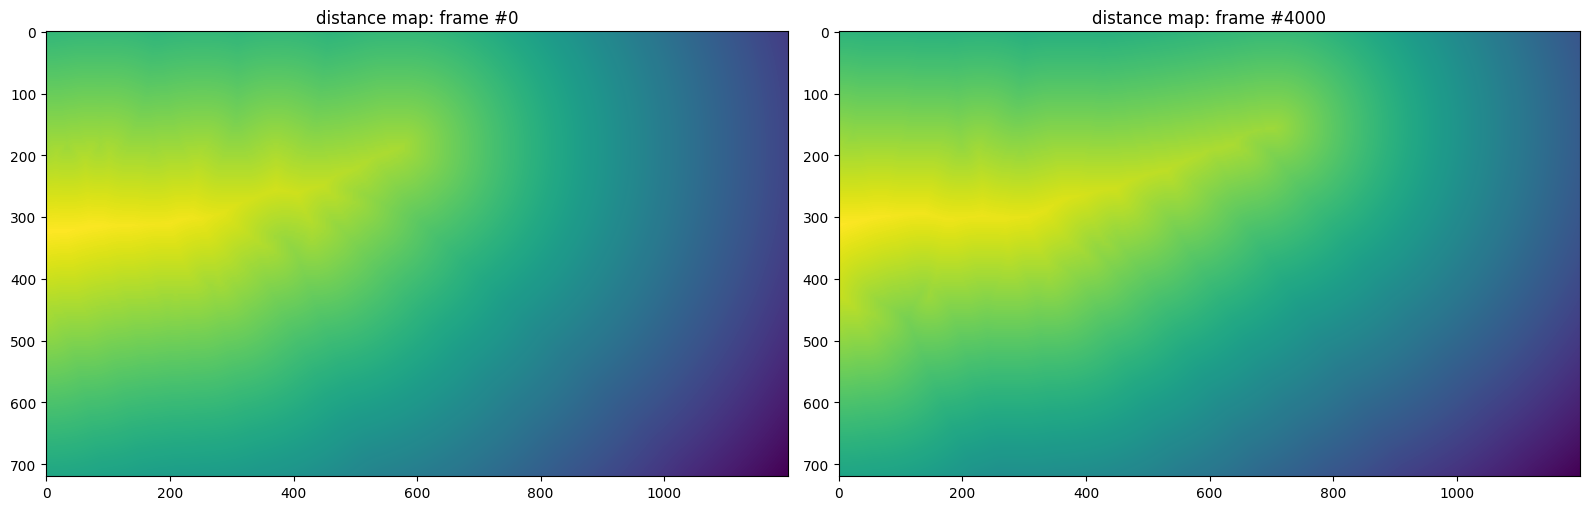

In [56]:
import cv2
import numpy as np

# Find images contours
cnt1, hrrch1 = cv2.findContours(image=img1, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
cnt2, hrrch2 = cv2.findContours(image=img2, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

# img1
mask1_in = np.zeros_like(img1)
cv2.drawContours(image=mask1_in, contours=cnt1, contourIdx=-1, color=255, thickness=-1)
mask1_out = cv2.bitwise_not(mask1_in)

dist1_in = cv2.distanceTransform(mask1_in, distanceType=cv2.DIST_L2, 
                                maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
dist1_out = cv2.distanceTransform(mask1_out, distanceType=cv2.DIST_L2, 
                                maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
dist1 = dist1_in - dist1_out

#img2
mask2_in = np.zeros_like(img2)
cv2.drawContours(image=mask2_in, contours=cnt2, contourIdx=-1, color=255, thickness=-1)
mask2_out = cv2.bitwise_not(mask2_in)

dist2_in = cv2.distanceTransform(mask2_in, distanceType=cv2.DIST_L2,
                                maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
dist2_out = cv2.distanceTransform(mask2_out, distanceType=cv2.DIST_L2,
                                maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
dist2 = dist2_in - dist2_out

# Show the distance maps  
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axs[0].imshow(dist1)
axs[0].set_title(f'distance map: frame #{frame1}');
axs[1].imshow(dist2)
axs[1].set_title(f'distance map: frame #{frame2}');
plt.tight_layout()

In [162]:
import numpy as np
import cv2
import rasterio
from scipy.interpolate import interp1d


def interpolate_mask(polygons, start_frame, end_frame, int_instance, int_kind='linear', out_dim=None):
    """
    Interpolates between two segmentation masks using the distances of their respective contours.

    Args:
    - polygons (list): A list of polygon of shapely polygons for each frame in the video.
    - start_frame (int): The index of the first frame to interpolate between.
    - end_frame (int): The index of the second frame to interpolate between.
    - int_instance (float): The fraction of the distance between start_frame and end_frame to interpolate at.
    - int_kind (str): The kind of interpolation to use. Can be one of 'linear',
                     'nearest', 'zero', 'slinear','previous', or 'next'. Default is 'linear'.
    - out_dim (tuple): The desired output dimensions of the interpolated mask. Default is (720, 1200).

    Returns:
    - image (numpy array): The interpolated segmentation mask.
    """
    if not isinstance(polygons, list) or len(polygons) < 2:
        raise ValueError("polygons should be a list of binary masks for at least two frames")
    
    if start_frame < 0 or start_frame >= len(polygons) or end_frame < 0 or end_frame >= len(polygons):
        raise ValueError("start_frame and end_frame should be valid indices of the polygons list")
    
    if int_instance < start_frame or int_instance > end_frame:
        raise ValueError("y_second should be a value between start_frame and end_frame")

    # Rasterize the binary masks for the start and end frames
    img1 = rasterio.features.rasterize([polygons[start_frame]], out_shape=(720, 1200))
    img2 = rasterio.features.rasterize([polygons[end_frame]], out_shape=(720, 1200))

    # Find the contours of the binary masks
    cnt1, _ = cv2.findContours(image=img1, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    cnt2, _ = cv2.findContours(image=img2, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

    # Compute the distance transform of the masks
    mask1_in = np.zeros_like(img1)
    cv2.drawContours(image=mask1_in, contours=cnt1, contourIdx=-1, color=255, thickness=-1)
    mask1_out = cv2.bitwise_not(mask1_in)
    dist1_in = cv2.distanceTransform(mask1_in, distanceType=cv2.DIST_L2,
                                    maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
    dist1_out = cv2.distanceTransform(mask1_out, distanceType=cv2.DIST_L2,
                                    maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
    dist1 = dist1_in - dist1_out
    mask2_in = np.zeros_like(img2)
    cv2.drawContours(image=mask2_in, contours=cnt2, contourIdx=-1, color=255, thickness=-1)
    mask2_out = cv2.bitwise_not(mask2_in)
    dist2_in = cv2.distanceTransform(mask2_in, distanceType=cv2.DIST_L2,
                                    maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
    dist2_out = cv2.distanceTransform(mask2_out, distanceType=cv2.DIST_L2,
                                    maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
    dist2 = dist2_in - dist2_out
    
    # Interpolate the distance transforms using the specified interpolation method
    int_instance_norm = (int_instance - start_frame) / (end_frame - start_frame)
    x_int = np.array([int_instance_norm])
    x_samples = [0, 1]
    dist1_2d = np.reshape(dist1, (720*1200,))
    dist2_2d = np.reshape(dist2, (720*1200,))
    ifunc = interp1d(x_samples, np.stack((dist1_2d, dist2_2d), axis=1), axis=1, kind=int_kind)
    img_int_2d = ifunc(x_int)
    img_int = np.reshape(img_int_2d, (720, 1200, 1))

    image = np.where(img_int[:,:,0] > 0, 255, 0).astype(np.uint8)

    if out_dim is not None:
        image = cv2.resize(img, dsize= out_dim, interpolation=cv2.INTER_CUBIC)

    return image

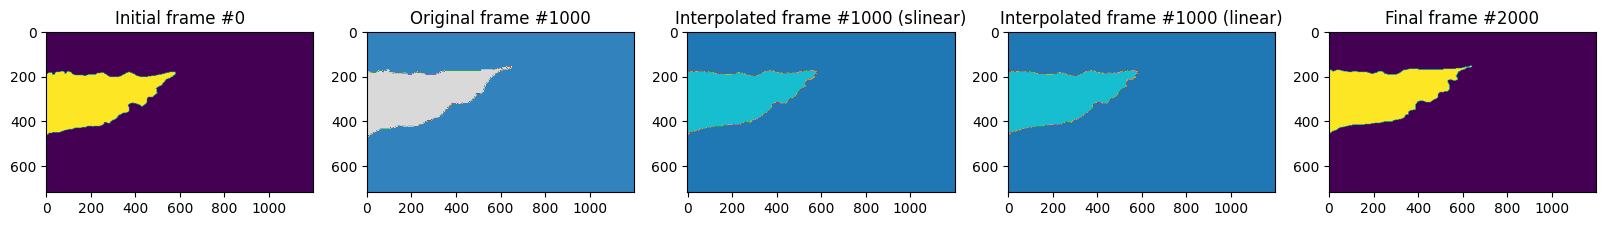

In [192]:
frame_init = 0
frame_end = 2000
n_delta_frames = 1000
img_int = rasterio.features.rasterize([polygons[frame_init]], out_shape=(720, 1200))
img_end = rasterio.features.rasterize([polygons[frame_end]], out_shape=(720, 1200))
img_o = rasterio.features.rasterize([polygons[frame_init+n_delta_frames]], out_shape=(720, 1200))
img_l = interpolate_mask(polygons, frame_init, frame_end, n_delta_frames, int_kind='linear')
img_s = interpolate_mask(polygons, frame_init, frame_end, n_delta_frames, int_kind='slinear')

# plot the initial and final frames, the original frame, and the frames generated by the interpolation
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(img_int)
ax[0].set_title(f'Initial frame #{frame_init}')
ax[1].imshow(img_o, cmap='tab20c')
ax[1].set_title(f'Original frame #{frame_init+n_delta_frames}')
ax[2].imshow(img_s, cmap='tab10')
ax[2].set_title(f'Interpolated frame #{frame_init+n_delta_frames} (slinear)')    
ax[3].imshow(img_l, cmap='tab10')	
ax[3].set_title(f'Interpolated frame #{frame_init+n_delta_frames} (linear)')
ax[4].imshow(img_end)
ax[4].set_title(f'Final frame #{frame_end}')
plt.show()

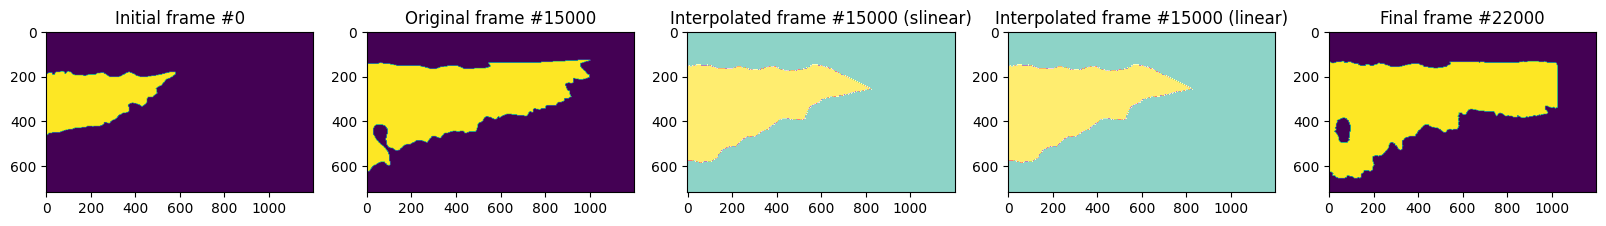

In [181]:
frame_init = 0
frame_end = 22000
n_delta_frames = 15000
img_int = rasterio.features.rasterize([polygons[frame_init]], out_shape=(720, 1200))
img_end = rasterio.features.rasterize([polygons[frame_end]], out_shape=(720, 1200))
img_o = rasterio.features.rasterize([polygons[frame_init+n_delta_frames]], out_shape=(720, 1200))
img_l = interpolate_mask(polygons, frame_init, frame_end, n_delta_frames, int_kind='linear')
img_s = interpolate_mask(polygons, frame_init, frame_end, n_delta_frames, int_kind='slinear')

# plot the initial and final frames, the original frame, and the frames generated by the interpolation
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(img_int)
ax[0].set_title(f'Initial frame #{frame_init}')
ax[1].imshow(img_o)
ax[1].set_title(f'Original frame #{frame_init+n_delta_frames}')
ax[2].imshow(img_s, cmap='Set3')
ax[2].set_title(f'Interpolated frame #{frame_init+n_delta_frames} (slinear)')    
ax[3].imshow(img_l, cmap='Set3')	
ax[3].set_title(f'Interpolated frame #{frame_init+n_delta_frames} (linear)')
ax[4].imshow(img_end)
ax[4].set_title(f'Final frame #{frame_end}')
plt.show()

In [182]:
%%time
img_l = interpolate_mask(polygons, frame_init, frame_end, n_delta_frames, int_kind='linear')

CPU times: total: 46.9 ms
Wall time: 40.9 ms


### Pyspatiotemporalgeom library
**Documentation:** http://www.cs.siue.edu/~marmcke/docs/pyspatiotemporalgeom/

**Note:** this library was writen in Python 2. It had to be converted to 
          Python 3 compatible code.

breakSegments

In [146]:
import math

def breakSegments(r1, cellsPerSeg=3):
    '''
    Given a bunch of line segments, break them at intersection points.  
    Handles overlapping segments appropriately (duplicates are removed).

    Input:
        r1: A list of segments of the form ``((x1,y1),(x2,y2))``
        cellsPerSeg: an integer indicating how many cells (roughly) a segment 
                     should fall into.  This is computed based on the average 
                     length of line segments in ``r1``.
    Output: 
        A list of segments such that segments only overlap at end points.
    '''

    # make sure all segs have left most point first
    r1 = [s if s[0] < s[1] else ((s[1][0], s[1][1]), (s[0][0], s[0][1])) for s in r1]

    # get avg length of segs
    sumOfr1Len = 0
    for s in r1:
        sumOfr1Len = sumOfr1Len + \
            (((s[0][0]-s[1][0])*(s[0][0]-s[1][0])) +
             ((s[0][1]-s[1][1])-(s[0][1]-s[1][1])))
    avgR1Len = math.sqrt(sumOfr1Len/len(r1))
    #print('avgR1Len: ', avgR1Len)
    # assign each segment roughly ``cellsPerSeg``
    cellSize = avgR1Len/cellsPerSeg

    # then give each seg an index
    # and reassign r1
    # we are also adding an integer to indicate if the interior
    indexedR1 = []
    for i in range(len(r1)):
        indexedR1.append((r1[i][0], r1[i][1], i))
    r1 = indexedR1

    # Assign the cells
    cellDict1 = dict()
    usedCells1 = set()
    assignCells(r1, cellSize, cellDict1, usedCells1)

    # for any cells that have more than 1 seg, compute intersections among them

    pois1 = []
    # look for the intersection points
    for key in cellDict1:
        for i in range(len(cellDict1[key])-1):
            for j in range(i+1, len(cellDict1[key])):
                # compute intersection point.
                s1 = cellDict1[key][i]
                s2 = cellDict1[key][j]
                x1 = s1[0][0]
                y1 = s1[0][1]
                x2 = s1[1][0]
                y2 = s1[1][1]
                x3 = s2[0][0]
                y3 = s2[0][1]
                x4 = s2[1][0]
                y4 = s2[1][1]

                # check for colinear overlapping case
                if segLibrary.isCollinearAndOverlapping(s1, s2):
                    ll = x1
                    lu = x2
                    rl = x3
                    ru = x4
                    # if theya are near vertical, use the y vals
                    if abs(x1-x2) < 0.0000001:
                        ll = y1
                        lu = y2
                        rl = y3
                        ru = y4
                    if rl < ll and ll < ru:
                        intersectPoi = (s2[2], (x1, y1))
                        pois1.append(intersectPoi)
                    if rl < lu and lu < ru:
                        intersectPoi = (s2[2], (x2, y2))
                        pois1.append(intersectPoi)
                    if ll < rl and rl < lu:
                        intersectPoi = (s1[2], (x3, y3))
                        pois1.append(intersectPoi)
                    if ll < ru and ru < lu:
                        intersectPoi = (s1[2], (x4, y4))
                        pois1.append(intersectPoi)
                    continue

                # if an end point is shared, no intersection
                if s1[0] == s2[0] or s1[0] == s2[1] or s1[1] == s2[0] or s1[1] == s2[1]:
                    continue

                denom = ((y4-y3)*(x2-x1)) - ((x4-x3)*(y2-y1))
                if denom == 0.0:  # lines are parallel, no intersection
                    continue

                ua = ((x4-x3)*(y1-y3))-((y4-y3)*(x1-x3))
                ua = ua / denom
                ub = ((x2-x1)*(y1-y3))-((y2-y1)*(x1-x3))
                ub = ub / denom
                # if we get here, the lines are not parallel.  they must intersect somewhere
                # check for intersections in a seg interior
                # record the segs so that we can construct the resulting segs
                if 0.0 < ua and ua < 1.0 and 0.0 <= ub and ub <= 1.0:
                    x = x1 + (ua * (x2-x1))
                    y = y1 + (ua * (y2-y1))
                    intersectPoi = (s1[2], (x, y))
                    if intersectPoi[1] != s1[0] and intersectPoi[1] != s1[1]:
                        pois1.append(intersectPoi)

                if 0.0 < ub and ub < 1.0 and 0.0 <= ua and ua <= 1.0:
                    x = x1 + (ua * (x2-x1))
                    y = y1 + (ua * (y2-y1))
                    intersectPoi = (s2[2], (x, y))
                    if intersectPoi[1] != s2[0] and intersectPoi[1] != s2[1]:
                        pois1.append(intersectPoi)

    pois1 = list(set(pois1))
    pois1.sort()

    # print 'done intersect, now build'
    # build the resulting segs
    r1 = segLibrary.constructSegs(pois1, r1)
    # print 'done build'

    r1 = segLibrary.snapEndPoints(r1)

    return r1

assignCells

In [80]:
def assignCells(r1, cellSize, r1Dict, usedCellSet):
    '''
        find cells using left hand turn test
    '''

    for s in r1:
        # print '-assign', s
        x1 = s[0][0]
        y1 = s[0][1]
        x2 = s[1][0]
        y2 = s[1][1]

        # get the starting and ending grids
        startGridX = int(x1 // cellSize) + 1
        startGridY = int(y1 // cellSize) + 1
        endGridX = int(x2 // cellSize) + 1
        endGridY = int(y2 // cellSize) + 1
        goingUp = True
        if y2-y1 < 0:
            goingUp = False
        x = startGridX
        y = startGridY

        while True:
            # print x,y,cellSize, x*cellSize, y*cellSize, endGridX, endGridY, goingUp
            # add the  grid
            if (x, y) not in r1Dict:
                r1Dict[(x, y)] = list()
            r1Dict[(x, y)].append(s)
            usedCellSet |= set([(x, y)])
            # check if we are on a boundary and add those cells
            addedLeft = False   # record if we added cell to left
            addedDown = False   # record if we added cell on bottom
            if math.fmod(x1, cellSize) == 0.0:
                # print 'added', x-1,y
                addedLeft = True
                # x value is on a boundary.  it will be on the larger boundary
                # (due to mod math), so we need to add the cell to the left
                if (x-1, y) not in r1Dict:
                    r1Dict[(x-1, y)] = list()
                r1Dict[(x-1, y)].append(s)
                usedCellSet |= set([(x-1, y)])
            # check if we add cell below because we are on the boundary
            # if line goes down, we might duplicate the seg in that cell.  CHECK BACK
            if math.fmod(y1, cellSize) == 0.0:
                addedDown = True
                if (x, y-1) not in r1Dict:
                    r1Dict[(x, y-1)] = list()
                r1Dict[(x, y-1)].append(s)
                usedCellSet |= set([(x, y-1)])
                # print 'added', x,y-1
            # if we were on both the left and down boundary, we were on the corner!
            # add the diagonal cell.
            if addedLeft and addedDown:
                if (x-1, y-1) not in r1Dict:
                    r1Dict[(x-1, y-1)] = list()
                r1Dict[(x-1, y-1)].append(s)
                usedCellSet |= set([(x-1, y-1)])
                # print 'added', x-1,y-1

            if x >= endGridX and ((goingUp and y >= endGridY) or (not goingUp and y <= endGridY)):
                break

            # figure out which cell to visit next
            # if the line goes next through the upper, lower, or left cells
            # then adjust accordingly. If it goes through the point to a diagonal
            # cell, go directly there, it will add the other cells based on the
            # boundary mod math
            # So... first check the diagonal points
            diagX = x * cellSize
            diagHiY = y * cellSize
            diagLoY = (y-1) * cellSize
            # now see if our line goes through (diagX, diagHiY) or (diagX, diagLoY)
            colinValueHi = segLibrary.collinearValue(
                (x1, y1), (diagX, diagHiY), (x2, y2))
            colinValueLo = segLibrary.collinearValue(
                (x1, y1), (diagX, diagLoY), (x2, y2))
            if abs(colinValueHi) < 0.0000001:
                # it goes through the upper diagonal
                x += 1
                y += 1
            elif colinValueHi > 0:
                # it goes through the upper cell bound
                y += 1
            elif abs(colinValueLo) < 0.0000001:
                # it goes through the lower diagonal
                x += 1
                y -= 1
            elif colinValueLo > 0:
                # it goes through the right boundary
                x += 1
            else:
                # it goes through the lower boundary
                y -= 1
    # print 'dict:', r1Dict
    # print 'usedCell', usedCellSet

createRegionFromSegs

In [137]:
from functools import cmp_to_key
def createRegionFromSegs( segs ):
        '''
        Constructs a well formed region from an input set line segments.  
        
        input:

        **segs**: a list of line segments in the format [((x1,y1),(x2,y2)),((x3,y3),(x4,y4)),...]
        Intersecting segments will be broken at intersection points.  If not cycle is present, no region
        will be returned.

        returns:
             
             **hsegs**:  an ordered list of half segments with valid labels.  
                 
                 A **half segment** is a tuple with the following:
                      ((x,y)(x,y), labelAbove, labelBelow)
                     
                     labels are integral values
                     
                     an interior label will be positive.  An exterior label will be -1.  The side of the hseg
                     on which the interior (exterior) of the region lies will have an interior (exterior) label.
                 
                 hsegs will be ordered in half segment order
                 
                 Each cycle in hsegs will have its own unique label number
        '''
        if segs == None or len(segs) == 0:
                return []
        segs = [((float(s[0][0]),float(s[0][1])), (float(s[1][0]), float(s[1][1])) ) for s in segs]
        newSegs = []
        for s in segs:
                if s[0] < s[1]:
                        newSegs.append( s )
                else:
                        newSegs.append( (s[1],s[0]) )
        segs = newSegs
        segs = breakSegments(segs)
        #print('breakSegments output: ', segs)
        #segs = segLibrary.calcNonIntersectingSegs( segs )
        hsegs = labelUniqueCycles( segs )
        #print('labelUniqueCycles output: ', hsegs)
        return switchLabelsForCorrectCycleLabelling( hsegs )

labelUniqueCycles

In [102]:
from collections import deque
def labelUniqueCycles(segs, onlyReturnOuterCycle=False):
    '''
    will do interior walks around cycles.  

    Each cycle will get a unique label.

    Label numbers will not necessarily start at 2, and may skip numbers

    Will also remove sticks!!!  a full service solution!

    Cycles will have unique labels, but holes in particular will have labelling flipped.  

    Use: def switchLabelsForCorrectCycleLabelling( hsegs ): to finalize labels

    This function is used to create well-formed regions from possibly non-wellformed input.

    **input**: 

    segs: a list of segs.

    onlyReturnOuterCycle:  if you want a simple region, set this to true!

    **output**: a hseg list representing a well formed region. Agian, call def switchLabelsForCorrectCycleLabelling( hsegs ): to finalize labels!!!  Everything is labeled as an outercycle after this call.
    '''
    # remove dups from segs
    nonDupSegs = []
    for s in segs:
        if s[0] < s[1]:
            nonDupSegs.append(s)
        else:
            nonDupSegs.append((s[1], s[0]))
    seenSegSet = set(nonDupSegs)
    segs = list(seenSegSet)
    # convert segs to hsegs
    hsegs = []
    for s in segs:
        hsegs.append(((s[0], s[1]), -1, -1))
        hsegs.append(((s[1], s[0]), -1, -1))
    hsegs.sort(key=cmp_to_key(hsegCompForSorted))
    # create a hash table for the seg portions mapped to their index
    indexLookup = dict()
    for i, h in enumerate(hsegs):
        indexLookup[h[0]] = i

    # visit unprocessed segs in hseg order.  Each unprocessed will start a new cycle
    currLabel = 1
    nestedLabel = 2
    for i, h in enumerate(hsegs):
        if (h[1] == -1 and h[2] == -1) and isLeft(h):  # unprocessed, left
            #nestedLabel = currLabel+1
            # interior walk the cycle
            visitedPoiSet = set()
            seenSegSet = set()
            visitedHsegStack = deque()
            completeVisitedHistoryStack = deque()
            currIndex = i
            startIndex = i
            firstTimeThrough = True
            currLabel = nestedLabel
            nestedLabel += 1
            labellingAbove = True
            startHseg = hsegs[startIndex]
            while True:
                currHseg = hsegs[currIndex]
                # check if this is a stick seg.  If so, just label it as invalid and move on
                if (currHseg[0][1], currHseg[0][0]) in seenSegSet:
                    # we have walked its brother.  this is a stick. label it as such
                    hsegs[currIndex] = (currHseg[0], 0, 0)
                    brotherIndex = indexLookup[(
                        currHseg[0][1], currHseg[0][0])]
                    brother = hsegs[brotherIndex]
                    brother = (brother[0], 0, 0)
                    hsegs[brotherIndex] = brother
                    # If this happens to be the brother of the startHseg, we need to unvisit the
                    # walked cycle. (since we walked the exterior and may have walked mutliple stick-connected cycles)
                    if brother[0] == hsegs[startIndex][0]:
                        for itemHseg in completeVisitedHistoryStack:
                            if itemHseg[1] != 0:
                                itemIndex = indexLookup[itemHseg[0]]
                                brotherIndex = indexLookup[(
                                    itemHseg[0][1], itemHseg[0][0])]
                                hsegs[itemIndex] = (itemHseg[0], -1, -1)
                                hsegs[brotherIndex] = (
                                    (itemHseg[0][1], itemHseg[0][0]), -1, -1)
                        break
                # check if we have reached a processed seg (happpnes if we started on a stick)
                # we have to process first seg twice
                elif (currHseg[1] > 0 or currHseg[2] > 0) and currIndex != startIndex:
                    # we must have started on a stick, and followed it to get here.
                    # mark everything we followed as such
                    visitedHsegStack.appendleft(startHseg)
                    for itemHseg in visitedHsegStack:
                        itemIndex = indexLookup[itemHseg[0]]
                        brotherIndex = indexLookup[(
                            itemHseg[0][1], itemHseg[0][0])]
                        hsegs[itemIndex] = (itemHseg[0], 0, 0)
                        hsegs[brotherIndex] = (
                            (itemHseg[0][1], itemHseg[0][0]), 0, 0)
                    break
                # final case we have an unprocessed, non-stick seg.
                # label it appropriately
                else:
                    # label the current hseg and its brother
                    la = currLabel
                    lb = -1
                    if not labellingAbove:
                        lb = currLabel
                        la = -1

                    hsegs[currIndex] = (currHseg[0], la, lb)
                    brotherIndex = indexLookup[(
                        currHseg[0][1], currHseg[0][0])]
                    brother = hsegs[brotherIndex]
                    brother = (brother[0], la, lb)
                    hsegs[brotherIndex] = brother

                    # if we have closed a loop, pop and fix
                    if currHseg[0][0] in visitedPoiSet:
                        stopPoi = currHseg[0][0]

                        while True:
                            # debug statment.  We are about to pop a stack.  if it is empty, this prog
                            # will crash.  So, preemptively printout the current region. current seg,

                            # end of debug statement
                            # pop it, updateLabels
                            # print currHseg
                            poppedHseg = visitedHsegStack.popleft()

                            poppedIndex = indexLookup[poppedHseg[0]]
                            poppedIndexBrother = indexLookup[(
                                poppedHseg[0][1], poppedHseg[0][0])]
                            if hsegs[poppedIndex][1] > 0:
                                hsegs[poppedIndex] = (
                                    poppedHseg[0], nestedLabel, -1)
                                hsegs[poppedIndexBrother] = (
                                    (poppedHseg[0][1], poppedHseg[0][0]), nestedLabel, -1)
                            elif hsegs[poppedIndex][2] > 0:
                                hsegs[poppedIndex] = (
                                    poppedHseg[0], -1, nestedLabel)
                                hsegs[poppedIndexBrother] = (
                                    (poppedHseg[0][1], poppedHseg[0][0]), -1, nestedLabel)
                            if poppedHseg[0][0] == stopPoi:
                                break
                        nestedLabel += 1

                # update visited stacks and get the next seg
                if firstTimeThrough:
                    firstTimeThrough = False
                else:
                    # if not first time through, record point and seg, check stopping condition
                    visitedPoiSet |= set([currHseg[0][0]])
                    visitedHsegStack.appendleft(currHseg)
                    completeVisitedHistoryStack.appendleft(currHseg)
                    if currIndex == startIndex:
                        # if we get here, we finished a cycle
                        # if we only want the outer cycle, we can jsut return it here
                        if onlyReturnOuterCycle:
                            hsegs = [h for h in hsegs if h[1] != h[2]]
                            return hsegs
                        break

                seenSegSet |= set([(currHseg[0])])

                # get next hseg
                prevIndex = currIndex
                currIndex = getNextInnerCycleWalkIndex(
                    currHseg, hsegs, indexLookup)
                # check if we are switching label above
                if isLeft(hsegs[prevIndex]) != isLeft(hsegs[currIndex]):
                    labellingAbove = not labellingAbove

    hsegs = [h for h in hsegs if h[1] != h[2]]
    return hsegs

switchLabelsForCorrectCycleLabelling

In [91]:
def switchLabelsForCorrectCycleLabelling(hsegs):
    '''
    Assumes all cycles have a unique label. Labels can start at any number and can skip  numbers.

    Use labelUniqueCycles() to guarantee that cycles have unique label numbers.

    Assumes that cycles are labeled consistently, but possibly with the exterior on the incorrect side.

    This function will flip labels for all cycles that need it.

    Approach: find the first seg in each cycle.  Do a point in polygon test for the midpoint of that seg.

    this will tell us if it is a hole or outer cycle.  then flip labels accordingly

    **input**: hsegs: a list of hsegs indicating a well-formed region, but with hole labels labeled as outer cycles.

    **output**: a well formed region with appropriate labels.
    '''
    # make sure seg labels start at 2 and don't skip
    oldIndexToNewIndexDict = dict()
    counter = 2
    for h in hsegs:
        label = h[1]*h[2]*-1
        if label not in oldIndexToNewIndexDict:
            oldIndexToNewIndexDict[label] = counter
            counter += 1
    oldIndexToNewIndexDict[-1] = -1
    hsegs = [(h[0], oldIndexToNewIndexDict[h[1]],
              oldIndexToNewIndexDict[h[2]]) for h in hsegs]
    # now labels are correct
    #maxLabeledHseg = max( hsegs, key=lambda h: h[1]*h[2]*-1 )
    maxLabel = counter-1  # maxLabeledHseg[1]*maxLabeledHseg[2]*-1
    counts = [0]*(maxLabel+1)
    cycleSeg = [None]*(maxLabel+1)
    #cyclePoint = [None]*(maxLabel+1)
    seenSet = set()
    for h in hsegs:
        num = h[1]*h[2]*-1
        if num not in seenSet:
            seenSet |= set([num])
            cycleSeg[num] = h
    #               cyclePoint[num] = ( (h[0][0][0]+h[0][1][0])/float(2),  (h[0][0][1]+h[0][1][1])/float(2))
    # now we have the points.  Do the point in polygon test. shoot a ray down
    # only test against segs that are not in the current cycle
    start = 2
    end = maxLabel+1
    for h in hsegs:
        # only look at left, non vertical segs
        if isLeft(h) and h[0][0][0] != h[0][1][0]:
            for i in range(start, end):
                if h[0] == cycleSeg[i]:  # don't test the seg we go tthe point from
                    continue
                # elif h[0][0][0] >= cyclePoint[maxLabel][0]: # got past the cycle point
                    break
                # hseg does not reach any more cyc points
                elif h[0][1][0] <= cycleSeg[i][0][0][0]:
                    break
                elif h[0][0][0] > cycleSeg[i][0][0][0]:  # hseg is past current check point
                    start += 1
                    continue
                # share a dom point, use cycSeg sub point in LHTtest
                elif h[0][0] == cycleSeg[i][0][0]:
                    if isLeftTurn(h[0][0], h[0][1], cycleSeg[i][0][1]) == 1:
                        counts[i] += 1
                else:  # elif h[0][1][0] > cyclePoint[i][0]: # hsegs spans the point in the x direction. and has different dom point
                    # we checked that h[0][0][0] is <= to cycPoi X val and that h[0][1][0] > cycPoi X val
                    # now check if h[0][0], h[0][1], cycPoi is a left hand turn.  if so, h is belowthe poi,
                    # h is not vertical, and h spans the poi in the X direction
                    if isLeftTurn(h[0][0], h[0][1], cycleSeg[i][0][0]) == 1:
                        counts[i] += 1
    # now we now how many segs lie below each cycle.  odd counts mean a hole.  even counts mean an outer cycle
    holeLabelSet = set([i for i, c in enumerate(counts) if c % 2 == 1])
    outercycleLabelSet = set([i for i, c in enumerate(counts) if c % 2 == 0])
    for i, h in enumerate(hsegs):
        label = h[1]*h[2]*-1
        if label in holeLabelSet and cycleSeg[label][1] > 0:
            hsegs[i] = (h[0], h[2], h[1])
        elif label in outercycleLabelSet and cycleSeg[label][2] > 0:
            hsegs[i] = (h[0], h[2], h[1])
    return hsegs


exampleCreateRandomRegionsAndInterpolate

In [2]:
import pyspatiotemporalgeom.intervalRegion as intervalRegion
import pyspatiotemporalgeom.region as region

def exampleCreateRandomRegionsAndInterpolate():
  '''
  An example that creates two random regions and interpolates them to create a moving region.

  See the documentation for pyspatiotemporalgeom.movingRegion.interpolateRegions() for more details.
  '''
  r1 = []
  r2 = []
  while len( r1 ) == 0 or len( r2 ) == 0:
    r1 = region.getRandomRegion( 50 )
    r2 = region.getRandomRegion( 50 )
  print('length of input regions (number of halfsegments)')
  print(len( r1 ), ' ', len(r2))
  print('interpolating: ')
  print(intervalRegion.interpolateRegions(r1, r2, 10, 20))

  return intervalRegion.interpolateRegions(r1, r2, 10, 20)


region = exampleCreateRandomRegionsAndInterpolate()

length of input regions (number of halfsegments)
476   524
interpolating: 
([((459.2987911384145, 6432.929760362442, 10), (466.6778121659669, 6210.575260065531, 10), (459.2987911384145, 6432.929760362442, 12.0), True), ((459.2987911384145, 6432.929760362442, 12.0), (466.6778121659669, 6210.575260065531, 12.0), (466.6778121659669, 6210.575260065531, 10), True), ((466.6778121659669, 6210.575260065531, 12.0), (1148.8809250592435, 5902.045454110065, 12.0), (466.6778121659669, 6210.575260065531, 10), False), ((466.6778121659669, 6210.575260065531, 10), (1148.8809250592435, 5902.045454110065, 10), (1148.8809250592435, 5902.045454110065, 12.0), True), ((1148.8809250592435, 5902.045454110065, 12.0), (1685.5329937035974, 4973.257070739758, 12.0), (1148.8809250592435, 5902.045454110065, 10), False), ((1148.8809250592435, 5902.045454110065, 10), (1685.5329937035974, 4973.257070739758, 10), (1685.5329937035974, 4973.257070739758, 12.0), True), ((1685.5329937035974, 4973.257070739758, 12.0), (1661.

In [42]:
from pyspatiotemporalgeom.utilities import segLibrary
import math
import bisect


def breakSegments(r1, cellsPerSeg=3):
    '''

    given a bunch of line segments, break them at intersection points.  Handles overlapping segments appropriately (duplicates are removed).

    Input:

    r1
        A list of segments of the form ``((x1,y1),(x2,y2))``

    cellsPerSeg
        an integer indicating how many cells (roughly) a segment should fall into.  This is computed based on the average length of line segments in ``r1``.

    Output:

    A list of segments such that segments only overlap at end points.

    '''

    # make sure all segs have left most point first
    r1 = [s if s[0] < s[1] else (s[1], s[0]) for s in r1]

    # get avg length of segs
    sumOfr1Len = 0
    for s in r1:
        sumOfr1Len = sumOfr1Len + \
            (((s[0][0]-s[1][0])*(s[0][0]-s[1][0])) +
             ((s[0][1]-s[1][1])-(s[0][1]-s[1][1])))
        
    avgR1Len = math.sqrt(sumOfr1Len/len(r1))

    # assign each segment roughly ``cellsPerSeg``
    cellSize = avgR1Len/cellsPerSeg

    # then give each seg an index
    # and reassign r1
    # we are also adding an integer to indicate if the interior
    indexedR1 = []
    for i in range(len(r1)):
        indexedR1.append((r1[i][0], r1[i][1], i))
    r1 = indexedR1

    # Assign the cells
    cellDict1 = dict()
    usedCells1 = set()
    assignCells(r1, cellSize, cellDict1, usedCells1)

    # for any cells that have more than 1 seg, compute intersections among them

    pois1 = []
    # look for the intersection points
    for key in cellDict1:
        for i in range(len(cellDict1[key])-1):
            for j in range(i+1, len(cellDict1[key])):
                # compute intersection point.
                s1 = cellDict1[key][i]
                s2 = cellDict1[key][j]
                x1 = s1[0][0]
                y1 = s1[0][1]
                x2 = s1[1][0]
                y2 = s1[1][1]
                x3 = s2[0][0]
                y3 = s2[0][1]
                x4 = s2[1][0]
                y4 = s2[1][1]

                # check for colinear overlapping case
                if segLibrary.isCollinearAndOverlapping(s1, s2):
                    ll = x1
                    lu = x2
                    rl = x3
                    ru = x4
                    # if theya are near vertical, use the y vals
                    if abs(x1-x2) < 0.0000001:
                        ll = y1
                        lu = y2
                        rl = y3
                        ru = y4
                    if rl < ll and ll < ru:
                        intersectPoi = (s2[2], (x1, y1))
                        pois1.append(intersectPoi)
                    if rl < lu and lu < ru:
                        intersectPoi = (s2[2], (x2, y2))
                        pois1.append(intersectPoi)
                    if ll < rl and rl < lu:
                        intersectPoi = (s1[2], (x3, y3))
                        pois1.append(intersectPoi)
                    if ll < ru and ru < lu:
                        intersectPoi = (s1[2], (x4, y4))
                        pois1.append(intersectPoi)
                    continue

                # if an end point is shared, no intersection
                if s1[0] == s2[0] or s1[0] == s2[1] or s1[1] == s2[0] or s1[1] == s2[1]:
                    continue

                denom = ((y4-y3)*(x2-x1)) - ((x4-x3)*(y2-y1))
                if denom == 0.0:  # lines are parallel, no intersection
                    continue

                ua = ((x4-x3)*(y1-y3))-((y4-y3)*(x1-x3))
                ua = ua / denom
                ub = ((x2-x1)*(y1-y3))-((y2-y1)*(x1-x3))
                ub = ub / denom
                # if we get here, the lines are not parallel.  they must intersect somewhere
                # check for intersections in a seg interior
                # record the segs so that we can construct the resulting segs
                if 0.0 < ua and ua < 1.0 and 0.0 <= ub and ub <= 1.0:
                    x = x1 + (ua * (x2-x1))
                    y = y1 + (ua * (y2-y1))
                    intersectPoi = (s1[2], (x, y))
                    if intersectPoi[1] != s1[0] and intersectPoi[1] != s1[1]:
                        pois1.append(intersectPoi)

                if 0.0 < ub and ub < 1.0 and 0.0 <= ua and ua <= 1.0:
                    x = x1 + (ua * (x2-x1))
                    y = y1 + (ua * (y2-y1))
                    intersectPoi = (s2[2], (x, y))
                    if intersectPoi[1] != s2[0] and intersectPoi[1] != s2[1]:
                        pois1.append(intersectPoi)

    pois1 = list(set(pois1))
    pois1.sort()

    # print 'done intersect, now build'
    # build the resulting segs
    r1 = segLibrary.constructSegs(pois1, r1)
    # print 'done build'

    r1 = segLibrary.snapEndPoints(r1)
    return r1


def assignCells(r1, cellSize, r1Dict, usedCellSet):
    '''
        find cells using left hand turn test
    '''

    for s in r1:
        # print '-assign', s
        x1 = s[0][0]
        y1 = s[0][1]
        x2 = s[1][0]
        y2 = s[1][1]

        # get the starting and ending grids
        startGridX = int(x1 // cellSize) + 1
        startGridY = int(y1 // cellSize) + 1
        endGridX = int(x2 // cellSize) + 1
        endGridY = int(y2 // cellSize) + 1
        goingUp = True
        if y2-y1 < 0:
            goingUp = False
        x = startGridX
        y = startGridY

        while True:
            # print x,y,cellSize, x*cellSize, y*cellSize, endGridX, endGridY, goingUp
            # add the  grid
            if (x, y) not in r1Dict:
                r1Dict[(x, y)] = list()
            r1Dict[(x, y)].append(s)
            usedCellSet |= set([(x, y)])
            # check if we are on a boundary and add those cells
            addedLeft = False   # record if we added cell to left
            addedDown = False   # record if we added cell on bottom
            if math.fmod(x1, cellSize) == 0.0:
                # print 'added', x-1,y
                addedLeft = True
                # x value is on a boundary.  it will be on the larger boundary
                # (due to mod math), so we need to add the cell to the left
                if (x-1, y) not in r1Dict:
                    r1Dict[(x-1, y)] = list()
                r1Dict[(x-1, y)].append(s)
                usedCellSet |= set([(x-1, y)])
            # check if we add cell below because we are on the boundary
            # if line goes down, we might duplicate the seg in that cell.  CHECK BACK
            if math.fmod(y1, cellSize) == 0.0:
                addedDown = True
                if (x, y-1) not in r1Dict:
                    r1Dict[(x, y-1)] = list()
                r1Dict[(x, y-1)].append(s)
                usedCellSet |= set([(x, y-1)])
                # print 'added', x,y-1
            # if we were on both the left and down boundary, we were on the corner!
            # add the diagonal cell.
            if addedLeft and addedDown:
                if (x-1, y-1) not in r1Dict:
                    r1Dict[(x-1, y-1)] = list()
                r1Dict[(x-1, y-1)].append(s)
                usedCellSet |= set([(x-1, y-1)])
                # print 'added', x-1,y-1

            if x >= endGridX and ((goingUp and y >= endGridY) or (not goingUp and y <= endGridY)):
                break

            # figure out which cell to visit next
            # if the line goes next through the upper, lower, or left cells
            # then adjust accordingly. If it goes through the point to a diagonal
            # cell, go directly there, it will add the other cells based on the
            # boundary mod math
            # So... first check the diagonal points
            diagX = x * cellSize
            diagHiY = y * cellSize
            diagLoY = (y-1) * cellSize
            # now see if our line goes through (diagX, diagHiY) or (diagX, diagLoY)
            colinValueHi = segLibrary.collinearValue(
                (x1, y1), (diagX, diagHiY), (x2, y2))
            colinValueLo = segLibrary.collinearValue(
                (x1, y1), (diagX, diagLoY), (x2, y2))
            if abs(colinValueHi) < 0.0000001:
                # it goes through the upper diagonal
                x += 1
                y += 1
            elif colinValueHi > 0:
                # it goes through the upper cell bound
                y += 1
            elif abs(colinValueLo) < 0.0000001:
                # it goes through the lower diagonal
                x += 1
                y -= 1
            elif colinValueLo > 0:
                # it goes through the right boundary
                x += 1
            else:
                # it goes through the lower boundary
                y -= 1
    # print 'dict:', r1Dict
    # print 'usedCell', usedCellSet

hsegCompForSorted

In [95]:
def hsegCompForSorted(L, R):
    '''
    wrapper for halfsegment comparison function used for the sorted library.
    '''
    if L[0] == R[0]:
        return 0
    elif hsegComp(L, R):
        return -1
    else:
        return 1

hsegComp

In [97]:
def hsegComp(L, R):
    '''
    Halfsegment comparison function.  Used to provide a total ordering on halfsegments

    **input**: two halfsegments

    **output**: True if L < R, False otherwise
    '''
    if L[0][0] < R[0][0]:
        return True
    elif L[0][0] == R[0][0]:
        if not isLeft(L) and isLeft(R):
            return True
        elif isLeft(L) == isLeft(R):
            if collinear(L, R):  # same dominating point and collinear
                high1 = L[0][1] if (L[0][0] < L[0][1]) else L[0][0]
                low1 = L[0][1] if (L[0][0] > L[0][1]) else L[0][0]
                high2 = R[0][1] if (R[0][0] < R[0][1]) else R[0][0]
                low2 = R[0][1] if (R[0][0] > R[0][1]) else R[0][0]

                xdif1 = high1[0] - low1[0]
                xdif2 = high2[0] - low2[0]
                ydif1 = high1[1] - low1[1]
                ydif2 = high2[1] - low2[1]

                xdif1 = xdif1*-1 if (xdif1 < 0) else xdif1
                xdif2 = xdif2*-1 if (xdif2 < 0) else xdif2
                ydif1 = ydif1*-1 if (ydif1 < 0) else ydif1
                ydif2 = ydif2*-1 if (ydif2 < 0) else ydif2

                return ((xdif1 < xdif2) or (ydif1 < ydif2))
            else:  # smallest is that with smallest slope
                if (L[0][0][0] == L[0][1][0]):  # infinite going slope, definitely not smaller
                    return False
                elif (R[0][0][0] == R[0][1][0]):  # inifinite going slope, definitely smaller
                    return True
                else:
                    return slope(L[0]) < slope(R[0])
        else:
            return False
    else:
        return False

isLeft

In [100]:
def isLeft(hseg):
    '''
    returns true if the input halfsegment is a left halfsegment, false otherwise

    A halfsegment has the structure: (((x1,y1),(x2,y2)),la,lb) where la,lb are ints
    '''
    return hseg[0][0] < hseg[0][1]

getNextInnerCycleWalkIndex

In [104]:
def getNextInnerCycleWalkIndex(searchHseg, hsegs, indexLookupDict):
    '''
    when traversing a cycle in cyclic order, find the next halfsegment by rotating the current segment through the INTERIOR of the cycle.

    This will find smaller cycles, but will interpret a well formed region correctly.

    **input**: 

    searchHseg.  The current hseg from which the next hseg in cyclic order is found

    hsegs: a hseg list forming a region

    indexLookupDict:  a hash table mapping segments to their corresponding halfsegment index in the hsegs list.

    **output**: the next hsed in cyclic order.
    '''
    # find the brother
    index = indexLookupDict[(searchHseg[0][1], searchHseg[0][0])]
    domPoi = searchHseg[0][1]
    if index < 0:
        raise Exception('did not find hseg: getNextInnerCycleWalkIndex')
    # now rotate clockwise
    if index > 0 and domPoi == hsegs[index-1][0][0]:
        return index-1
    else:  # need to jump to last seg around this point
        while index < len(hsegs)-1 and domPoi == hsegs[index+1][0][0]:
            index += 1
        if domPoi != hsegs[index][0][0]:
            print((searchHseg[0][1], searchHseg[0][0]),
                  searchHseg[1], searchHseg[2])
            raise Exception(' did not find CW walk seg: getNextInnerCycleWalk')
        return index

collinear

In [126]:
def collinear(L, R):
    '''
    returns true if L and R are EXACTLY collinear.  Check the collinearity functions in segLibrary if a tolerance is allowed.
    '''
    x1 = L[0][0][0]
    y1 = L[0][0][1]
    x2 = L[0][1][0]
    y2 = L[0][1][1]
    x3 = R[0][0][0]
    y3 = R[0][0][1]
    x4 = R[0][1][0]
    y4 = R[0][1][1]

    denom = ((y4-y3)*(x2-x1)) - ((x4-x3)*(y2-y1))
    if denom == 0.0:
        return True
    return False

slope

In [128]:
def slope(seg):
    '''
    return the slope of a line segment.

    **input**:  A SEGMENT, not a halfsegment.

    **output**: a float
    '''
    if seg[0][0] == seg[1][0]:
        return 0
    return ((seg[0][1]-seg[1][1]) / float((seg[0][0]-seg[1][0])))

isLeftTurn

In [130]:
def isLeftTurn(p1, p2, p3):
    '''
    Another left hand turn test.

    When traveling from point p1 to pont p2, do we take a left or right turn to travel on th point p3?

    **input**: 3 points, p1, p2, p3 in (x,y) format

    **output**: -1 if its a left turn, 0 if the points ar collinear, 1 if its a right turn.
    '''
    p1x = p1[0]
    p1y = p1[1]
    p2x = p2[0]
    p2y = p2[1]
    p3x = p3[0]
    p3y = p3[1]
    result = ((p3y - p1y) * (p2x - p1x)) - ((p2y - p1y) * (p3x - p1x))
    if result > 0:
        return 1
    elif result == 0:
        return 0

interpolateRegions

In [134]:
from pyspatiotemporalgeom.utilities import regionInterpolator
def interpolateRegions(region1, region2, startTime, endTime, noTriIntersectionChecks=False):
    '''
    This is just a wrapper that calls ``pyspatiotemporalgeom.utilities.regionInterpolater.interpolate()``.  
    Create an interpolation between two well-formed regions over a time interval 
    (defined by ``startTime`` and ``endTime``) such that at every instant within
    that time interval, the region resulting from the interpolation at that instant 
    conforms to the type definition of complex regions as defined in [1]. Note 
    that the various region generators and region creation functions int he
    region.py file create well formed regions according to [1].  In otherwords, 
    the moving region resulting from this function conforms to the type definition 
    of moving regions in [2]. This function is an extension of the algorithm in 
    [3] to handle both simple (1 simple cycle with no holes) regions and complex 
    regions.


    [1] Markus Schneider and Thomas Behr. 2006. Topological relationships between 
        complex spatial objects. ACM Trans. Database Syst. 31, 1 (March 2006), 
        39-81. DOI=10.1145/1132863.1132865 http://doi.acm.org/10.1145/1132863.1132865
    [2] Ralf Hartmut Guting, Michael H. Bohlen, Martin Erwig, Christian S. 
        Jensen, Nikos A. Lorentzos, Markus Schneider, and Michalis Vazirgiannis. 
        2000. A foundation for representing and querying moving objects. 
        ACM Trans. Database Syst. 25, 1 (March 2000), 1-42. 
        DOI=10.1145/352958.352963 http://doi.acm.org/10.1145/352958.352963
    [3] Mark McKenney and James Webb. 2010. Extracting moving regions from 
        spatial data. In Proceedings of the 18th SIGSPATIAL International 
        Conference on Advances in Geographic Information Systems (GIS '10). 
        ACM, New York, NY, USA, 438-441. DOI=10.1145/1869790.1869856 
        http://doi.acm.org/10.1145/1869790.1869856

    Input:

    1. r1, r2: two well formed regions represented as lists of hlafsegments. 
    Any of the region creation functions in region.py will do.

    2. startTime, endTime:  two numbers defining a time interval. 
    These numbers are used as the 3D dimension when extrapolating into 3D space.

    3. noTriIntersectionChecks. See paper [3]. The algorithm first creates an
    interpolation between the input regions.  It is possible that the 
    interpolation will result in a self-intersecting region at some point.  
    The triangle/triangle intersection test is then performed.  This test is 
    very computationally intensive (especially for python) and can take a LONG 
    time to compute. If you pass a ``True`` for this argument, the tri/tri 
    intersection test is skipped, and the interpolation returned AS-IS (possibly 
    with self-intersections). This makes the algorithm :math:`O(n \lg n)` 
    instead of :math:`O(n^2)`.

    Output:

    A 3-tuple. See [3]. The algorithm will create at MOST, 3 interval regions 
    to describe the interpolation of r1 to r2 over the defined time interval. 
    Not all 3 interval regions are always required, so 1 or 2 of the values in 
    the tuple may be ``None``, but a 3 tuple is ALWAYS returned.  If the 
    ``noTriIntersectionChecks`` argument is set to ``True``, or the original 
    interpolation succeeds, then the return value will look like this: 
    ``(None, triList, None)``.
    Any non-``None`` value in the return tuple will be a list of triangles 
    describing the movement of line segments in r1 as they travel across 
    the defined interval to r2 (between intermediate states of r1 and r2 
    if necessary).
    '''
    return regionInterpolator.interpolate(region1, region2, startTime, endTime, noTriIntersectionChecks)

points_to_segments (auxiliary function to convert Shapely polygons to Pyspatiotemporalgeom *segs*)

In [ ]:
def points_to_segments(points):
    """
    Converts a list of points into a list of line segments.

    Args:
        points: A list of (x,y) tuples representing the points of the polygon.

    Returns:
        A list of line segments as tuples of two (x,y) tuples.
    """
    segments = list()
    for i in range(len(points)-1):
        segments.append((points[i], points[i+1]))
    # connect last point to first point
    segments.append((points[-1], points[0]))
    return segments

testing Pyspatiotemporalgeom

In [184]:
from functools import cmp_to_key
from pprint import pprint

# example of valid line segments
segs1 = [((1.0, 1.0),(5.0,1.0)),((5.0,1.0),(3.0,5.0)),((3.0,5.0),(1.0,1.0))]
segs2 = [((1.0,2.0),(4.0,1.0)),((4.0,1.0),(5.0,1.0)),((5.0,1.0),(1.0,3.0)),((1.0,3.0),(1.0,2.0))]
# polygon points
points1 = [(1, 1), (5,1), (3,5), (1,1)]

segs3 = [((5,1),(5,2)),((5,2),(6,2)),((6,2),(5,1))]
segs4 = [((1,1),(5,5)),((3,1),(3,5)),((2,5),(5,4)),((1,1),(2,2))]
segs5 = [((0,4),(3,0)),((3,0),(8,4)),((8,4),(0,4))]

#pol_0 = points_to_segments(list(polygons[0].exterior.coords))
#pol_10000 = points_to_segments(list(polygons[10000].exterior.coords))

# 'source region'
pol_0 = points_to_segments(segs1)
# 'destination region'
pol_10000 = points_to_segments(segs2)

# constructs well formed regions from an input set line segments

# r1 = createRegionFromSegs(pol_0)

# r2 = createRegionFromSegs(pol_10000)


r1 = createRegionFromSegs(segs1)
r2 = createRegionFromSegs(segs5)

In [187]:
%%time
int_region = interpolateRegions(region1=r1,
                                region2=r2, 
                                startTime=10,
                                endTime=200,
                                noTriIntersectionChecks=False)

                                
# We assume that a moving segment always consists of a segment and a point; 
# therefore, a segment will either contract to a point over time or a point will
# expand into a segment over time interval. Thus, a moving segment consists of a 
# segment, a point and a FLAG indicating whether the segment or as a point.
# (True: moving segment begins as a segment, False: moving segment begins as a 
# point)

pprint(int_region)

(None,
 [((1.0, 1.0, 10), (5.0, 1.0, 10), (0.0, 4.0, 200), True),
  ((5.0, 1.0, 10), (3.0, 5.0, 10), (8.0, 4.0, 200), True),
  ((3.0, 5.0, 10), (1.0, 1.0, 10), (0.0, 4.0, 200), True),
  ((0.0, 4.0, 200), (3.0, 0.0, 200), (5.0, 1.0, 10), True),
  ((3.0, 0.0, 200), (8.0, 4.0, 200), (5.0, 1.0, 10), True),
  ((8.0, 4.0, 200), (0.0, 4.0, 200), (3.0, 5.0, 10), True)],
 None)
CPU times: total: 0 ns
Wall time: 997 µs


In [9]:
import pyspatiotemporalgeom.structureRegion as structureRegion
from pyspatiotemporalgeom.componentMovingRegion import cIntervalRegion
from pyspatiotemporalgeom.componentMovingRegion import intersection
import os

sr1 = structureRegion.structuralRegion()
sr1f1 = [((2, 1), (4, 1)), ((4, 1), (3, 4)), ((3, 4), (2, 1))]
sr1h1 = [((4, 2), (5, 2)), ((5, 2), (5, 3)), ((5, 3), (4, 2))]
sr1f1ID = sr1.addFace(sr1f1)
#sr1h1 = sr1.addHole( sr1h1, [sr1f1ID] )

sr2 = structureRegion.structuralRegion()
sr2f1 = [((2, 1), (4, 1)), ((4, 1), (3, 4)), ((3, 4), (2, 1))]
sr2h1 = [((1, 2), (2, 2)), ((2, 2), (2, 3)), ((2, 3), (1, 2))]
sr2f1ID = sr2.addFace(sr2f1)



#sr2h1 = sr2.addHole( sr2h1, [sr2f1ID] )
sr3 = structureRegion.structuralRegion()
sr3f1 = [((1, 1), (2, 1)), ((2, 1), (1, 2)), ((1, 2), (1, 1))]
sr3f1ID = sr3.addFace(sr3f1)
sr4 = structureRegion.structuralRegion()
sr4f1 = [((3, 3), (4, 3)), ((4, 3), (4, 4)), ((4, 4), (3, 3))]
sr4f1ID = sr4.addFace(sr4f1)

t1 = 10
t2 = 20

# use the structural regions to create component interval regions
interReg1 = cIntervalRegion()
interReg1.sourceSR = sr1
interReg1.destSR = sr2
interReg1.sourceTime = t1
interReg1.destTime = t2
interReg1.mapComponent(sr1f1ID, sr2f1ID)
#interReg1.mapComponent( sr1h1, sr2h1)
print('interReg1')
print(interReg1)

# interReg2 = cIntervalRegion()
# interReg2.sourceSR = sr3
# interReg2.destSR = sr4
# interReg2.sourceTime = t1
# interReg2.destTime = t2
# interReg2.mapComponent(sr3f1ID, sr4f1ID)
# print('interReg2')
# print(interReg2)


# print('Intersection:')
# result = intersection(interReg1, interReg2)
# os.makedirs('C:\\Users\\tiago\\miniconda3\\envs\\interpol\\tmp', exist_ok=True)
# TEMP_DIR = 'C:\\Users\\tiago\\miniconda3\\envs\\interpol\\tmp'
# of = open(os.path.join(TEMP_DIR, 'of.txt'), 'w')
# for c in result:
#     print(c)
#     print('++++++++++++++')
#     c.printToFileFor3DVis(of)
# of.close()

# if1 = open(os.path.join(TEMP_DIR,'if1.txt'), 'w')
# interReg1.printToFileFor3DVis(if1)
# if1.close()
# if1 = open(os.path.join(TEMP_DIR,'if2.txt'), 'w')
# interReg2.printToFileFor3DVis(if1)
# if1.close()

interReg1
10
F: 1: [((2, 1), (4, 1)), ((2, 1), (3, 4)), ((3, 4), (4, 1))]
H: L: P: Map: 
20
F: 1: [((2, 1), (4, 1)), ((2, 1), (3, 4)), ((3, 4), (4, 1))]
H: L: P: Map: Mapping:
{1: [1]}


10
F: 1: [((2, 1), (4, 1)), ((2, 1), (3, 4)), ((3, 4), (4, 1))]
H: L: P: Map: 
20
F: 1: [((2, 1), (4, 1)), ((2, 1), (3, 4)), ((3, 4), (4, 1))]
H: L: P: Map: Mapping:
{1: [1]} ---
10
F: 1: [((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 1))]
H: L: P: Map: 
20
F: 1: [((3, 3), (4, 3)), ((3, 3), (4, 4)), ((4, 3), (4, 4))]
H: L: P: Map: Mapping:
{1: [1]}
Intersection:
zlist:
[10, 15.0, 15.714285714285714, 16.666666666666664, 16.666666666666668, 17.272727272727273, 17.5, 20]
1
2
1
2
10
F: 1: [((2, 1), (4, 1)), ((2, 1), (3, 4)), ((3, 4), (4, 1))]
H: L: P: Map: 
F: 1: [((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 1))]
H: L: P: Map: 
^^^^^^^^^^^^
1
2
3
componentTris [(1, 1, [((2, 1, 10), (4, 1, 10), (2, 1, 20)), ((4, 1, 10), (3, 4, 10), (4, 1, 20)), ((3, 4, 10), (2, 1, 10), (3, 4, 20)), ((2, 1, 20), (4, 1, 20), (4, 1, 10)), ((4, 1, 20), (3, 4, 20), (3, 4, 10)), ((3, 4, 20), (2, 1, 20), (2, 1, 10))])]
segs:  [((2.0, 1.0), (3.0, 1.0)), ((4.0, 1.0), (3.5, 2.5)), ((3.0, 4.0), (2.5, 2.5)), ((3

In [166]:
points1 = [(1, 1), (5,1), (3,5), (1,1)]
pol1 = points_to_segments(list(polygons[0].exterior.coords))
r1 = createRegionFromSegs(pol1)
r1

[(((0.0, 194.0), (4.0, 194.0)), 2, -1),
 (((0.0, 194.0), (0.0, 467.0)), -1, 2),
 (((0.0, 467.0), (0.0, 194.0)), -1, 2),
 (((0.0, 467.0), (4.0, 467.0)), -1, 2),
 (((4.0, 191.0), (8.0, 191.0)), 2, -1),
 (((4.0, 191.0), (4.0, 194.0)), -1, 2),
 (((4.0, 194.0), (0.0, 194.0)), 2, -1),
 (((4.0, 194.0), (4.0, 191.0)), -1, 2),
 (((4.0, 464.0), (8.0, 464.0)), -1, 2),
 (((4.0, 464.0), (4.0, 467.0)), 2, -1),
 (((4.0, 467.0), (0.0, 467.0)), -1, 2),
 (((4.0, 467.0), (4.0, 464.0)), 2, -1),
 (((8.0, 188.0), (12.0, 188.0)), 2, -1),
 (((8.0, 188.0), (8.0, 191.0)), -1, 2),
 (((8.0, 191.0), (4.0, 191.0)), 2, -1),
 (((8.0, 191.0), (8.0, 188.0)), -1, 2),
 (((8.0, 461.0), (12.0, 461.0)), -1, 2),
 (((8.0, 461.0), (8.0, 464.0)), 2, -1),
 (((8.0, 464.0), (4.0, 464.0)), -1, 2),
 (((8.0, 464.0), (8.0, 461.0)), 2, -1),
 (((12.0, 186.0), (28.0, 186.0)), 2, -1),
 (((12.0, 186.0), (12.0, 188.0)), -1, 2),
 (((12.0, 188.0), (8.0, 188.0)), 2, -1),
 (((12.0, 188.0), (12.0, 186.0)), -1, 2),
 (((12.0, 456.0), (28.0, 456.0)

In [158]:
pprint(list(polygons[0].exterior.coords))

[(64.0, 180.0),
 (80.0, 180.0),
 (80.0, 183.0),
 (84.0, 183.0),
 (84.0, 191.0),
 (88.0, 191.0),
 (88.0, 188.0),
 (92.0, 188.0),
 (92.0, 183.0),
 (96.0, 183.0),
 (96.0, 180.0),
 (104.0, 180.0),
 (104.0, 183.0),
 (112.0, 183.0),
 (112.0, 186.0),
 (116.0, 186.0),
 (116.0, 191.0),
 (120.0, 191.0),
 (120.0, 194.0),
 (128.0, 194.0),
 (128.0, 197.0),
 (168.0, 197.0),
 (168.0, 200.0),
 (180.0, 200.0),
 (180.0, 197.0),
 (188.0, 197.0),
 (188.0, 194.0),
 (224.0, 194.0),
 (224.0, 191.0),
 (228.0, 191.0),
 (228.0, 188.0),
 (244.0, 188.0),
 (244.0, 186.0),
 (260.0, 186.0),
 (260.0, 191.0),
 (268.0, 191.0),
 (268.0, 194.0),
 (272.0, 194.0),
 (272.0, 197.0),
 (276.0, 197.0),
 (276.0, 200.0),
 (280.0, 200.0),
 (280.0, 202.0),
 (284.0, 202.0),
 (284.0, 205.0),
 (328.0, 205.0),
 (328.0, 202.0),
 (336.0, 202.0),
 (336.0, 200.0),
 (340.0, 200.0),
 (340.0, 197.0),
 (344.0, 197.0),
 (344.0, 194.0),
 (352.0, 194.0),
 (352.0, 191.0),
 (356.0, 191.0),
 (356.0, 188.0),
 (360.0, 188.0),
 (360.0, 186.0),
 (368.0,

# **TO DO LIST:**
### - Converter poligonos wkt em segmentos de reta compatíveis com Pyspatiotemporalgeom
### - Converter output da função *interpolateRegions* em poligonos shapely e/ou imagens

### Interpolation with optical flow

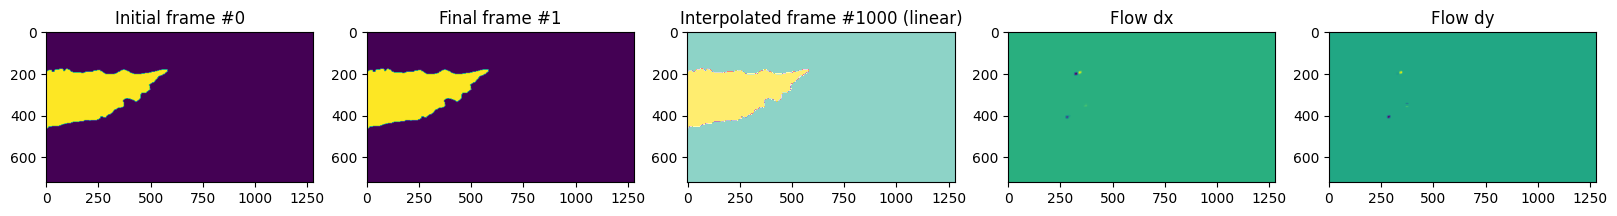

In [488]:
frame1 = 0
frame2 = 1

mask_0 = rasterio.features.rasterize([loads(multipolygons[frame1])], out_shape=(720, 1280))
mask_1 = rasterio.features.rasterize([loads(multipolygons[frame2])], out_shape=(720, 1280))

flow = cv2.calcOpticalFlowFarneback(prev =  mask_0, next = mask_1, flow = None,
                                    pyr_scale=0.5, levels=3, winsize=15, 
                                    iterations=3, poly_n=5, poly_sigma=1.1, 
                                    flags=0)

h, w = mask_1.shape[:2]
grid_x, grid_y = np.meshgrid(np.arange(w), np.arange(h))

dx = flow[:,:,0]*1280
dy = flow[:,:,1]*720

interp_x = grid_x + dx
interp_y = grid_y + dy

mask_interp = cv2.remap(src = mask_0, 
                        map1 = np.float32(interp_x), 
                        map2 = np.float32(interp_y), 
                        interpolation = cv2.INTER_LINEAR)

# plot the initial and final frames, the original frame, the frames generated by the interpolation and the flow

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
ax[0].imshow(mask_0)
ax[0].set_title(f'Initial frame #{frame1}')
ax[1].imshow(mask_1)
ax[1].set_title(f'Final frame #{frame2}')
ax[2].imshow(mask_interp, cmap='Set3')
ax[2].set_title(f'Interpolated frame #{frame1+n_delta_frames} (linear)')
ax[3].imshow(dx)
ax[3].set_title(f'Flow dx')
ax[4].imshow(dy)
ax[4].set_title(f'Flow dy')
plt.show()


array([0], dtype=uint8)

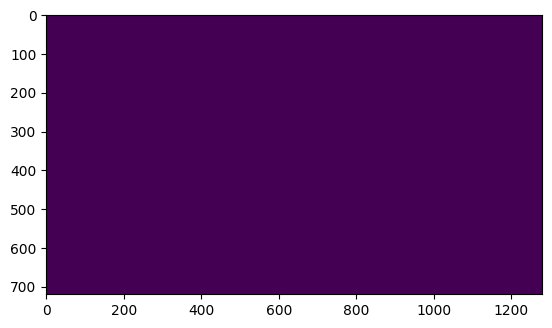

In [489]:
plt.imshow(mask_0-mask_interp)
np.unique(mask_0-mask_interp)

In [406]:
mask_interp = cv2.remap(src = np.float64(mask_0), map1 = interp_x, map2 = interp_y, interpolation = cv2.INTER_LINEAR)
plt.imshow(mask_interp)
np.max(mask_interp)

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:1815: error: (-215:Assertion failed) ((map1.type() == CV_32FC2 || map1.type() == CV_16SC2) && map2.empty()) || (map1.type() == CV_32FC1 && map2.type() == CV_32FC1) in function 'cv::remap'


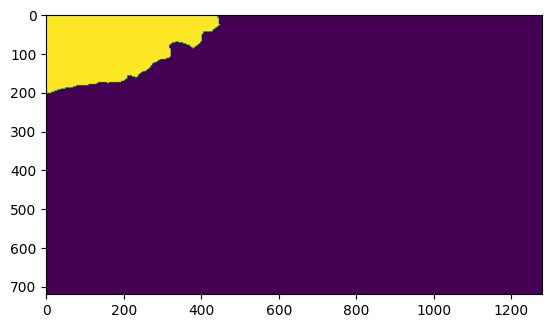

In [449]:
img = rasterio.features.rasterize([loads(multipolygons[0])], out_shape=(720, 1280))
# read image path and converts it to gr
#img = cv2.imread(frames_paths[0], cv2.IMREAD_GRAYSCALE)
# convert to CV_32FC2
# img = np.float64(img)

# Create a mapping function
map_x, map_y = np.meshgrid(np.arange(img.shape[1]), np.arange(img.shape[0]))
map_x = map_x + 50  # Example of shifting the image by 50 pixels in the x-direction
map_y = map_y + 250 # Example of shifting the image by 50 pixels in the y-direction


# Apply the mapping to the input image
remapped_img = cv2.remap(src = img, map1 = np.float32(map_x), map2 = np.float32(map_y), interpolation=cv2.INTER_AREA)
plt.imshow(remapped_img)

1329

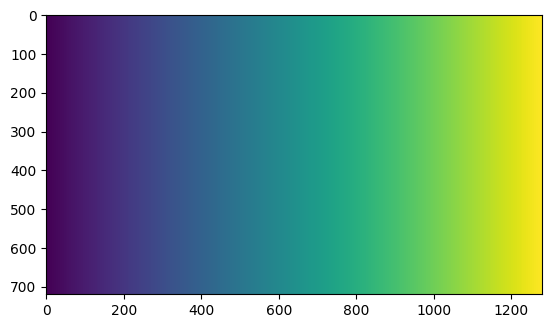

In [467]:
plt.imshow(map_x)
np.max(map_x)

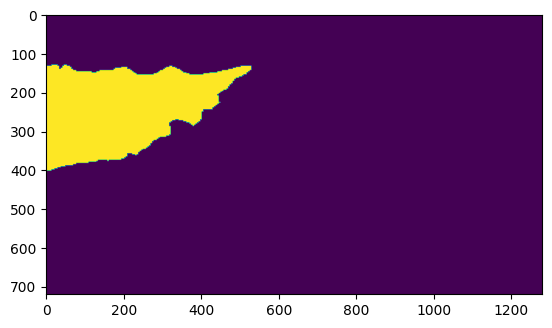

In [312]:
seg_0 = rasterio.features.rasterize([loads(multipolygons[0])], out_shape=(720, 1280))
seg_1 = rasterio.features.rasterize([loads(multipolygons[1000])], out_shape=(720, 1280))
img_0 = cv2.imread(frames_paths[0], cv2.IMREAD_GRAYSCALE)
img_1 = cv2.imread(frames_paths[100], cv2.IMREAD_GRAYSCALE)
# USAR Frames originais
flow = cv2.calcOpticalFlowFarneback(prev=img_0, next=img_1, 
                                    flow=None, pyr_scale=0.5, levels=3, 
                                    winsize=15, iterations=3, poly_n=5, 
                                    poly_sigma=1.1, flags=0)
    
# flow2 = cv2.calcOpticalFlowPyrLK(prevImg=img_0, nextImg=img_1,prevPts=None, nextPts=None)

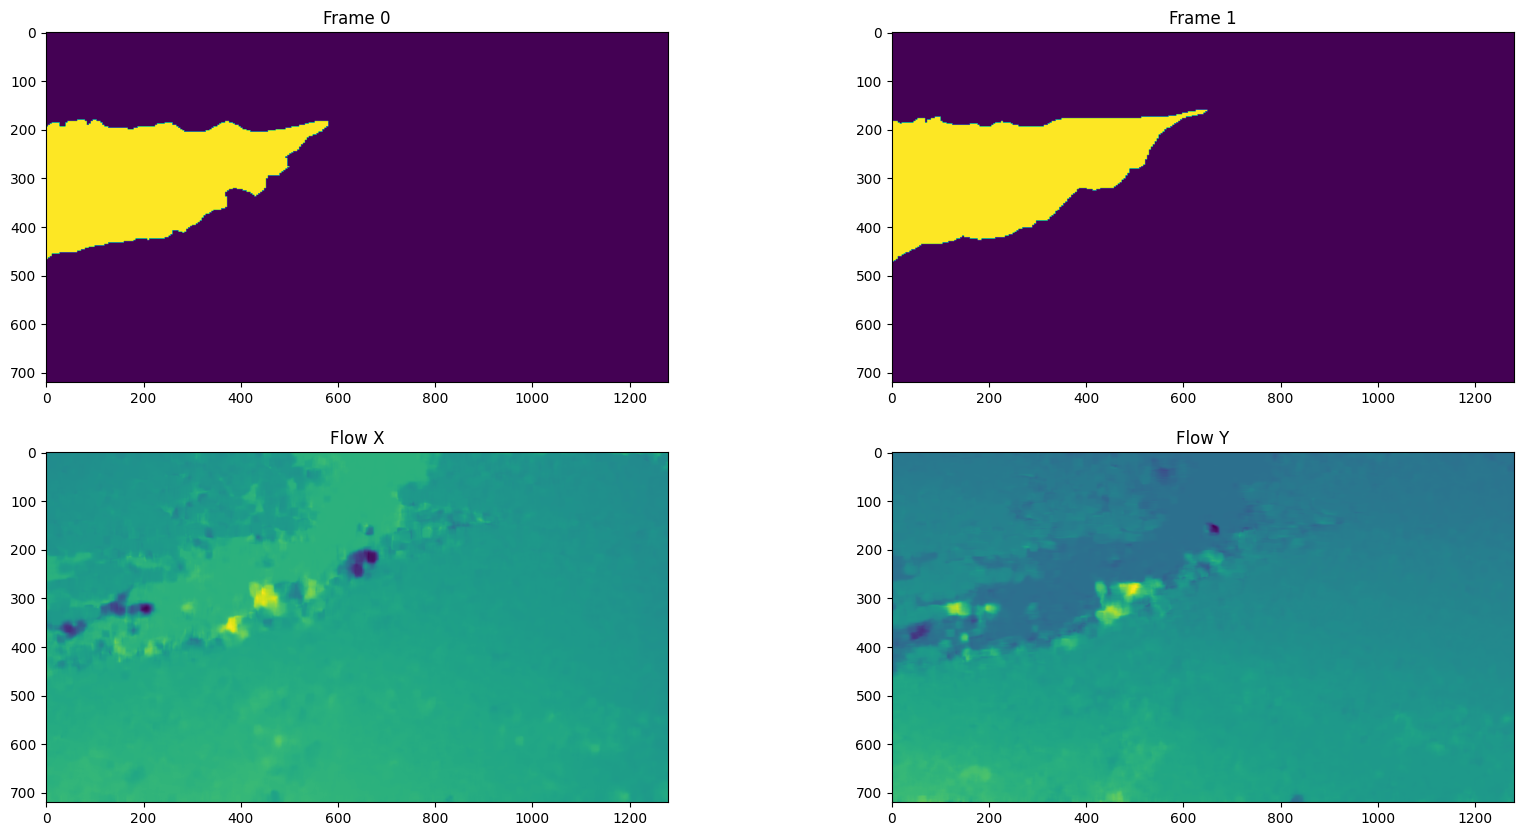

In [313]:
# plot 2 images from calcOpticalFlowFarneback and calcOpticalFlowPyrLK

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ax[0,0].imshow(seg_0)
ax[0,0].set_title('Frame 0')
ax[0,1].imshow(seg_1)
ax[0,1].set_title('Frame 1')
ax[1,0].imshow(flow[:,:,0])
ax[1,0].set_title('Flow X')
ax[1,1].imshow(flow[:,:,1])
ax[1,1].set_title('Flow Y')
plt.show();


In [316]:
# Interpolate intermediate frames using estimated optical flow
num_inter_frames = 1
for i in range(1, num_inter_frames+1):
    t = i / (num_inter_frames + 1)
    inter_frame = (1 - t) * seg_0 + t * seg_1
    
    # Warp pixels from previous frame to current frame using estimated optical flow
    warp_flow = -t * (1 - t) * flow
    inter_frame_warp = cv2.remap(seg_0, warp_flow[:, :, 0], warp_flow[:, :, 1], cv2.INTER_LINEAR)
    
    # Blend warped image with interpolated image to get final output image
    alpha = min(1.0 / i**0.6, 0.5)
    print(alpha)
    #alpha = 0.5
    output_frame = (1 - alpha) * inter_frame + alpha * inter_frame_warp

0.5


(1.0, 0.0)

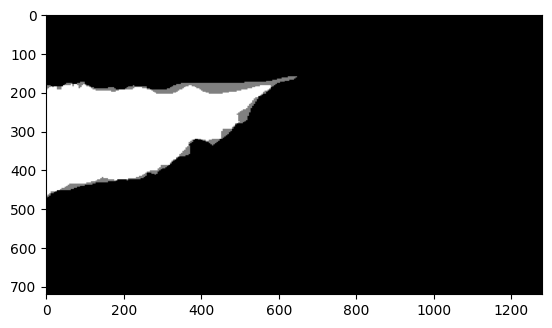

In [317]:
plt.imshow(output_frame, cmap='gray')	
np.max(inter_frame), np.min(inter_frame)

(8.816322, -15.727939)

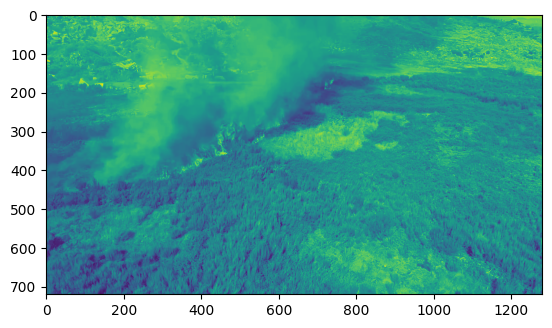

In [300]:
plt.imshow(img_0)
np.max(flow[:, :, 0]), np.min(flow[:, :, 0])

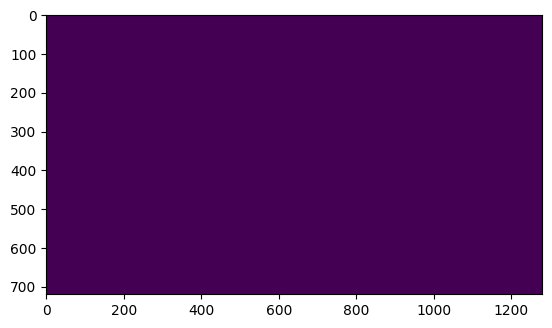

In [318]:
plt.imshow(inter_frame_warp)

In [242]:
np.max(inter_frame_warp)

0

In [234]:
inter_frame_warp

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [220]:
output_frame.shape

(720, 1200)

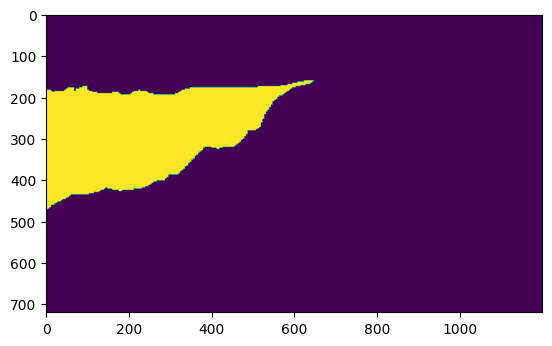

In [203]:
img_1 = rasterio.features.rasterize(loads([multipolygons[1000]]), out_shape=(720, 1200))
plt.imshow(img_1)


In [ ]:
# def oversample_masks(polygons, start_frame, end_frame, n_samples=1):

#     img1 = rasterio.features.rasterize([polygons[start_frame]], out_shape=(720, 1200))
#     img2 = rasterio.features.rasterize([polygons[end_frame]], out_shape=(720, 1200))

#     cnt1, _ = cv2.findContours(image=img1, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
#     cnt2, _ = cv2.findContours(image=img2, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

#     mask1_in = np.zeros_like(img1)
#     cv2.drawContours(image=mask1_in, contours=cnt1, contourIdx=-1, color=255, thickness=-1)
#     mask1_out = cv2.bitwise_not(mask1_in)

#     dist1_in = cv2.distanceTransform(mask1_in, distanceType=cv2.DIST_L2, 
#                                     maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
#     dist1_out = cv2.distanceTransform(mask1_out, distanceType=cv2.DIST_L2, 
#                                     maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
#     dist1 = dist1_in - dist1_out

#     mask2_in = np.zeros_like(img2)
#     cv2.drawContours(image=mask2_in, contours=cnt2, contourIdx=-1, color=255, thickness=-1)
#     mask2_out = cv2.bitwise_not(mask2_in)

#     dist2_in = cv2.distanceTransform(mask2_in, distanceType=cv2.DIST_L2,
#                                     maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
#     dist2_out = cv2.distanceTransform(mask2_out, distanceType=cv2.DIST_L2,
#                                     maskSize=cv2.DIST_MASK_PRECISE, dstType=cv2.CV_32F)
#     dist2 = dist2_in - dist2_out


#     x_int = np.linspace(0, 1, n_samples+2)[1:-1]
#     x_samples = [0, 1]

#     dist1_2d = np.reshape(dist1, (720*1200,))
#     dist2_2d = np.reshape(dist2, (720*1200,))

#     ifunc = interp1d(x_samples, np.stack((dist1_2d, dist2_2d), axis=1), axis=1, kind='linear')
#     img_int_2d = ifunc(x_int)
#     img_int = np.reshape(img_int_2d, (720, 1200, n_samples))

#     masks = []
#     masks.append(np.where(dist1 > 0, 1, 0).
